# Importación de bibliotecas

In [ ]:
import os
import pandas as pd
import torch
import json
import torchaudio
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import Adam
from torch.utils.data import Dataset
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
from transformers import Wav2Vec2Processor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
!pip freeze | grep -E "pandas|torch|torchaudio|wandb|transformers|scikit-learn"

geopandas==1.0.1
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.28.0
pandas-stubs==2.2.2.240909
scikit-learn==1.6.1
sentence-transformers==3.4.1
sklearn-pandas==2.2.0
torch @ https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl
transformers==4.51.3
wandb==0.19.10


LogIn en WandB

In [ ]:
!wandb login

wandb: Currently logged in as: pabloorlw (pabloorlw-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Obtención del dataset

In [ ]:
HOME = os.getcwd()
!mkdir {HOME}/data
%cd {HOME}/data

/content/data


Ficheros de audio y csv con etiquetas

In [ ]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "pabloorlw/RAVDESS_5_emotions"
filename = "RAVDESS_5_emotions.zip"

file_path = hf_hub_download(
    repo_id=hf_dataset_identifier,
    filename=filename,
    repo_type="dataset",
)

!unzip -q {file_path}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RAVDESS_5_emotions.zip:   0%|          | 0.00/53.7M [00:00<?, ?B/s]

# Carga de datos

In [ ]:
csv_path = "RAVDESS_5_emotions/ravdess_labels_5_emotions.csv"
df = pd.read_csv(csv_path)
df = df.dropna()

# Dividir en train, val y test
train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

# Codificar etiquetas
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["emotion"])
val_df["label"] = label_encoder.transform(val_df["emotion"])
test_df["label"] = label_encoder.transform(test_df["emotion"])

num_labels = len(label_encoder.classes_)


In [ ]:
MODEL_NAME = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
SAMPLE_RATE = 16000

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(MODEL_NAME)

preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

Dataset personalizado

In [ ]:
class RAVDESSDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        speech_array, sr = torchaudio.load(row["file"])
        if sr != SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
            speech_array = resampler(speech_array)

        inputs = feature_extractor(
            speech_array.squeeze().numpy(),
            sampling_rate=SAMPLE_RATE,
            return_tensors="pt",
            padding=True
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(row["label"])
        return inputs

train_dataset = RAVDESSDataset(train_df)
val_dataset = RAVDESSDataset(val_df)
test_dataset = RAVDESSDataset(test_df)

# Entrenamiento

Modelo y métricas

In [ ]:
# --- Modelo ---
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# --- Métricas ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- Hiperparámetros ---
num_epochs = 12
lr = 1e-4
batch_size = 4
eval_steps = 30
gradient_accumulation_steps = 2
save_steps = 150
logging_steps = 30
seed = 42

wandb.init(project="ravdess-emotion-wav2vec2", name="wav2vec2-ravdess-audio_6", config={
    "model": MODEL_NAME,
    "dataset": "RAVDESS",
    "sample_rate": SAMPLE_RATE,
    "epochs": num_epochs,
    "lr": lr,
    "batch_size": batch_size,
    "gradient_accumulation_steps": gradient_accumulation_steps,
    "save_steps" : save_steps,
    "eval_steps" : eval_steps,
    "logging_steps" : logging_steps,
    "seed": seed
})



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pabloorlw (pabloorlw-a) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
training_args = TrainingArguments(
    output_dir="../wav2vec2_ravdess_results_2",
    eval_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=lr,
    num_train_epochs=num_epochs,
    save_steps=save_steps,
    eval_steps=eval_steps,
    logging_steps=logging_steps,
    seed=seed,
    save_total_limit=2,
    report_to="wandb",
    optim="adamw_torch",  # AdamW optimizer
    lr_scheduler_type="linear",  # Ajuste a linear scheduler
)

optimizer = Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None)
)

trainer.train()

<ipython-input-12-a1efe166a037>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1
30,1.608700,1.527981,0.366667,0.302852
60,1.468800,1.596791,0.283333,0.183067
90,1.272100,1.494686,0.325000,0.217970
120,1.176000,1.235149,0.558333,0.531909
150,1.010000,1.102397,0.533333,0.479210
180,0.910800,1.137143,0.616667,0.588335
210,0.791400,0.941927,0.641667,0.621001
240,0.609000,1.080740,0.641667,0.639622
270,0.810700,1.028683,0.700000,0.694144
300,0.487200,0.865452,0.758333,0.750480


TrainOutput(global_step=1080, training_loss=0.3733091082492912, metrics={'train_runtime': 2002.2412, 'train_samples_per_second': 4.315, 'train_steps_per_second': 0.539, 'total_flos': 1.0267801318294004e+18, 'train_loss': 0.3733091082492912, 'epoch': 12.0})

# Evaluación del modelo en test

In [ ]:
results = trainer.evaluate(test_dataset)
print("Test Accuracy:", results["eval_accuracy"])
print("Test F1 Score:", results["eval_f1"])

# Logs personalizados en WandB
wandb.log({"Test Accuracy": results["eval_accuracy"], "Test F1": results["eval_f1"]})

Test Accuracy: 0.8
Test F1 Score: 0.8022061249410654


              precision    recall  f1-score   support

       angry       1.00      0.83      0.91        24
     fearful       0.83      0.79      0.81        24
       happy       0.77      0.71      0.74        24
         sad       0.78      0.88      0.82        24
   surprised       0.68      0.79      0.73        24

    accuracy                           0.80       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.81      0.80      0.80       120



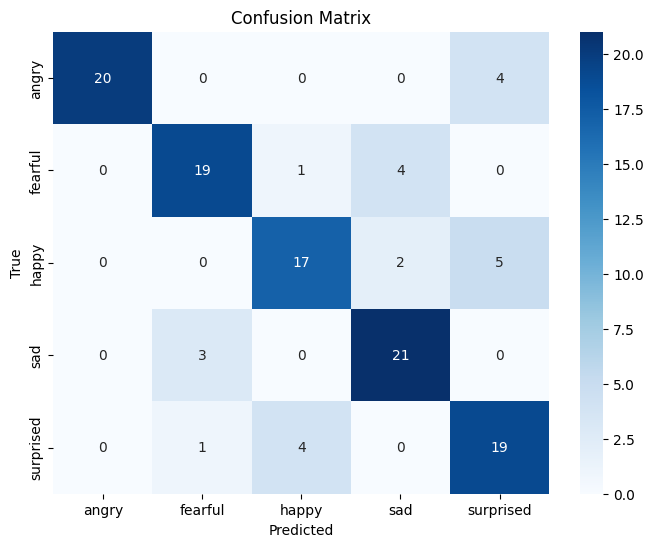

In [ ]:
# Predicciones
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

true_labels = test_dataset.df["label"].values

target_names = list(label_encoder.classes_)

# Reporte
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Guardado del modelo y etiquetas

In [ ]:
model.save_pretrained("../wav2vec2_ravdess_2")
feature_extractor.save_pretrained("../wav2vec2_ravdess_2")

label_map = {
    label: int(index)
    for label, index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
}

with open("../wav2vec2_ravdess_2/label_encoder.json", "w") as f:
    json.dump(label_map, f)